In [37]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


In [38]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [40]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(n_categories + input_size, self.hidden_size, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        lstm_input = torch.cat((category, input), dim=1).unsqueeze(0)  # Ensuring input is 3D: batch_size x seq_len x feature
        output, (hn, cn) = self.lstm(lstm_input, hidden) # Getting output and the last hidden and cell states
        output = self.fc(self.dropout(output.squeeze(0)))  # Removing the sequence length dimension before passing to the FC layer
        output = self.softmax(output)
        return output, (hn, cn)  # Returning the output and the hidden states as a tuple

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))  # Initializing both hidden and cell state

In [41]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [42]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [43]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [44]:
from torch.utils.data import Dataset

class NameDataset(Dataset):
    def __init__(self, all_categories, category_lines):
        self.all_categories = all_categories
        self.category_lines = category_lines
        self.n_samples = sum(len(lines) for lines in category_lines.values())

    def randomTrainingPair(self):
        category = random.choice(self.all_categories)
        line = random.choice(self.category_lines[category])
        return category, line

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        category, line = self.randomTrainingPair()
        return {'category': category, 'line': line}
dataset = NameDataset(all_categories, category_lines)

from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=34, shuffle=True)
for batch in dataloader:
    print(batch)
    category = batch['category'][0]
    line = batch['line'][0]
    print(category,line)

    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)

{'category': ['Arabic', 'French', 'Portuguese', 'Arabic', 'Japanese', 'English', 'Arabic', 'English', 'Chinese', 'Scottish', 'Polish', 'Chinese', 'Greek', 'Korean', 'Polish', 'Japanese', 'Vietnamese', 'Vietnamese', 'Japanese', 'Japanese', 'Dutch', 'Chinese', 'Russian', 'French', 'Chinese', 'German', 'Irish', 'Czech', 'Czech', 'Vietnamese', 'Japanese', 'Arabic', 'Russian', 'Italian'], 'line': ['Malouf', 'Salvage', 'Ferreira', 'Touma', 'Nozaki', 'Eggleston', 'Qureshi', 'Lynes', 'Kui', 'Munro', 'Chlebek', 'Deng', 'Calpis', 'Ron', 'Kedzierski', 'Iwasaki', 'Chu', 'Vinh', 'Kataoka', 'Watoga', 'Cann', 'Law', 'Ryjankov', 'St pierre', 'Yong', 'Rothbauer', 'Mcmahon', 'Wiesner', 'Mudra', 'Phan', 'Ozawa', 'Atiyeh', 'Abrahimov', 'Fiore']}
Arabic Malouf
{'category': ['Polish', 'Chinese', 'Korean', 'Dutch', 'English', 'Italian', 'Czech', 'Greek', 'French', 'Russian', 'Scottish', 'Italian', 'English', 'Korean', 'German', 'English', 'Scottish', 'Portuguese', 'Czech', 'Vietnamese', 'Dutch', 'Japanese', 

In [45]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

rnn = RNN(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


def trainRNN(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    optimizer.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

def trainLSTM(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = lstm.initHidden()

    lstm.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = lstm(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [46]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

rnn_losses = []
lstm_losses = []

In [47]:

n_iters = 300000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``


start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = trainRNN(*randomTrainingExample())
    total_loss += loss
   

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        rnn_losses.append(total_loss / plot_every)
        total_loss = 0


0m 5s (5000 1%) 3.1527
0m 11s (10000 3%) 2.7777
0m 16s (15000 5%) 2.0962
0m 22s (20000 6%) 1.8698
0m 27s (25000 8%) 2.5893
0m 33s (30000 10%) 2.2112
0m 38s (35000 11%) 2.2211
0m 44s (40000 13%) 2.5469
0m 49s (45000 15%) 2.9084
0m 55s (50000 16%) 2.2849
1m 1s (55000 18%) 3.0697
1m 6s (60000 20%) 2.2508
1m 12s (65000 21%) 2.1063
1m 17s (70000 23%) 1.9714
1m 23s (75000 25%) 2.5153
1m 29s (80000 26%) 1.8953
1m 34s (85000 28%) 1.8438
1m 40s (90000 30%) 1.7536
1m 45s (95000 31%) 2.0584
1m 50s (100000 33%) 2.8714
1m 56s (105000 35%) 1.8010
2m 1s (110000 36%) 2.1917
2m 7s (115000 38%) 2.9557
2m 12s (120000 40%) 2.3428
2m 18s (125000 41%) 1.5402
2m 23s (130000 43%) 2.1468
2m 28s (135000 45%) 2.2659
2m 34s (140000 46%) 2.6452
2m 39s (145000 48%) 2.3707
2m 45s (150000 50%) 1.4882
2m 50s (155000 51%) 1.3981
2m 56s (160000 53%) 2.1981
3m 1s (165000 55%) 2.0348
3m 7s (170000 56%) 2.0549
3m 12s (175000 58%) 2.0038
3m 17s (180000 60%) 2.0761
3m 23s (185000 61%) 0.8281
3m 28s (190000 63%) 3.0187
3m 33s

In [61]:
lstm = LSTM(n_letters, 128, n_letters)

n_iters = 500000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = trainLSTM(*randomTrainingExample())
    total_loss += loss
   

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        lstm_losses.append(total_loss / plot_every)
        total_loss = 0

0m 15s (5000 1%) 3.0424


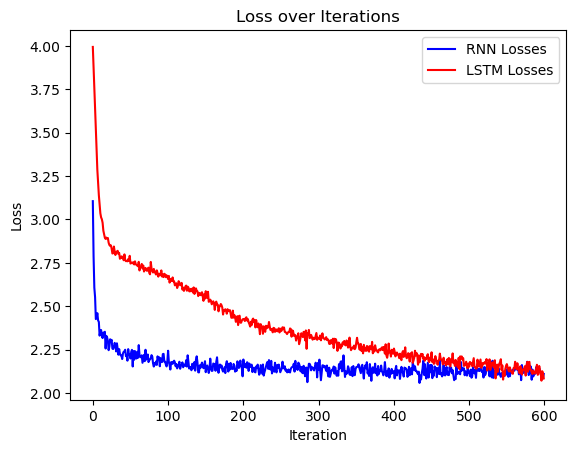

In [49]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(rnn_losses, label='RNN Losses', color='blue')
plt.plot(lstm_losses, label='LSTM Losses', color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.legend()
plt.show()

In [50]:
max_length = 20

def sample(category, start_letter='A', temperature=1.0):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            output = output / temperature  # Apply temperature
            probabilities = torch.exp(output)
            topi = torch.multinomial(probabilities, 1)  # Sample from the probability distribution
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

def samples(category, start_letters='ABC', temperature=1.0):
    results = []
    for start_letter in start_letters:
        results.append(sample(category, start_letter, temperature))
    return results

In [51]:
import torch

max_length = 20

def sample_lstm(category, start_letter='A', temperature=1.0):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = lstm.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = lstm(category_tensor, input[0], hidden)
            output = output / temperature  # Apply temperature
            probabilities = torch.exp(output)
            topi = torch.multinomial(probabilities, 1)  # Sample from the probability distribution
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

def samples_lstm(category, start_letters='ABC', temperature=1.0):
    results = []
    for start_letter in start_letters:
        results.append(sample_lstm(category, start_letter, temperature))
    return results

# You can now sample with different temperatures

# samples_lstm('Russian', 'PPP', temperature=0.2)
# samples_lstm('German', 'GER', temperature=0.2)
# samples_lstm('Spanish', 'SPA', temperature=0.2)
# samples_lstm('Chinese', 'CHINA', temperature=0.2)
# samples_lstm('English', 'ENG', temperature=0.2)


In [60]:

from prettytable import PrettyTable

def generate_samples(categories, start_letters='T', temperatures=[0.1, 0.2, 0.5]):
    for start_letter in start_letters:
        # Create a table instance
        table = PrettyTable()
        
        # Add a field for each category and an extra one for temperatures
        fields = ['Temperature'] + categories
        table.field_names = fields
        
        # Loop over temperatures to generate rows
        for temperature in temperatures:
            row = [temperature]
            for category in categories:
                # Generate a name using the RNN network (or LSTM, as per your setup)
                name = sample_lstm(category, start_letter, temperature)  # Change to sample_lstm for LSTM
                row.append(name)
            
            # Add the row to the table
            table.add_row(row)
        
        # Print the table
        print(f'Start Letter: {start_letter}')
        print(table)
        print('-' * 80)

# List of categories to generate samples for
categories = ['Portuguese', 'English', 'Greek', 'Polish', 'Portuguese', 'Korean', 'Chinese', 'Vietnamese', 'Scottish', 'French', 'English', 'Italian', 'Japanese', 'Italian', 'Vietnamese', 'Portuguese', 'English', 'Japanese', 'Dutch', 'English', 'Japanese', 'Russian', 'German', 'German', 'Korean', 'Scottish', 'Japanese', 'Arabic', 'Chinese', 'Italian', 'Japanese', 'Korean', 'Czech', 'Spanish']
categories = list(set(categories))
# Calling the function
generate_samples(categories)



Start Letter: T
+-------------+--------+----------+----------+------------+---------+-------------+---------+------------+---------+---------+----------+--------+---------+---------+--------+---------+--------+
| Temperature | German |  Dutch   | Scottish | Vietnamese | Spanish |    Greek    |  Czech  | Portuguese | Russian |  Polish | Japanese | Arabic | Chinese | Italian | French | English | Korean |
+-------------+--------+----------+----------+------------+---------+-------------+---------+------------+---------+---------+----------+--------+---------+---------+--------+---------+--------+
|     0.1     | Tarer  |  Tores   |  Tander  |    Thai    |  Tarin  |    Taris    | Taricha |   Tarra    |  Takhin | Talowak |  Taraka  | Taras  |   Tan   |  Tarito | Tarie  |  Tarter |  Thon  |
|     0.2     | Tonger | Toneres  |  Tanter  |    Tan     |  Talla  | Tastisoulos |  Tores  |   Taras    | Tarikov |  Tarono |   Taka   |  Tara  |   Tai   |  Tarti  | Tares  |  Tonter |  Thon  |
|     0.5